# Reading In and Cleaning California Alcohol Outlet Data

## Introduction
The California Alcohol Beverage Control maintains a [dataset](http://www.abc.ca.gov/datport/DataExport.html) of the current list of alcohol licenses in the state, which is exported weekly. This includes a wide range of license types for various on-premise or off-premise alcohol, each of which carries different privileges (beer only, winegrower, restaurant, etc). A single location can hold multiple license types (a wine grower can also sell wine, a restaurant can also have a bar, etc). The research organization I work for uses this type of data to study spatial relationships between sources of alcohol and alcohol related problems. 

Because of the way that this data is formatted, there are a number of steps that need to be taken along the way before it finds itself in a usable form. ```Pandas```, ```Geopandas```, and ```Geopy``` make this process relatively easy, as I demonstrate below. In the following notebook, I will:

1. Download the most recent export of California alcohol license data
2. Read in the fixed-with text file into Pandas
3. Aggregate license-level data to location-level data, identifying locations of three types of active alcohol outlets: off-premise outlets (liquor stores), bars, and restaurants. 
4. Geocode and get the lat/long coordinates of a subset of the data - all bars in San Francisco
5. Convert lat / long coordinates to projected GeoSeries as part of GeoDataFrame
6. Overlay point locations with a shapefile of SF neighborhoods to look at bar densities
7. Make a simple map using the built-in plotting feature in GeoPandas
8. Export the data as a shapefile for future use


In [23]:
#import necessary modules
%matplotlib inline
import zipfile, os, urllib
import pandas as pd
import numpy as np
import geopandas as gpd
import geopy
import os
import shapely
from shapely.geometry import Point
import geopandas.tools
import matplotlib.pyplot as plt


## Download Raw Alcohol License Data
Below I create a data directory and use ```urllib``` to dowload the data export and then ```zipfile``` to unzip it (if this hasn't been done already). I extract and print the name of the raw file which is an LST file. An LST file is just a plain text file that gets exported from some database programs.

In [24]:
if not os.path.exists('Data'):
    os.mkdir('Data')

URL='https://www.abc.ca.gov/datport/ABC_Data_Export.zip'
zip_file='Data/'+os.path.basename(URL)
if not os.path.exists(zip_file):
    urllib.urlretrieve(URL,zip_file)

z=zipfile.ZipFile(zip_file)

rawfile=[Item for Item in z.namelist()][0]
if not os.path.exists('Data/'+rawfile):
    z.extract(rawfile, 'Data')
rawfile='Data/'+rawfile
print rawfile

Data/m_tape460.LST


## Read in Data to Pandas
The ABC website contains (link above) contains a document that length of each field in the text file. The text file is in fixed-with format, which means that field lengths need to be specified in order for the data to be parsed correctly. Below I create lists that contain the length of each field as well as the name of each field.

In [25]:
col_lengths=[2,8,3,8,11,11,8,3,1,2,4,2,50,50,50,25,2,10,50,50,50,25,2,10,16,7]
col_names=['LicenseType','FileNum','LicenseOrApp','Status','OrigIssueDate','ExpirDate',\
           'FeeCodes','DupCounts','MasterIndicator','TermMonths','GeoCode','DistrictCode',\
           'pName','pAddress1','pAddress2','pCity','pState','pZip','DBAName','mAddress1',\
           'mAddress2','mCity','mState','mZip','pCounty','CensusTract']



Pandas can read in fixed width format files, but prefers to have the columns specified as a range of character positions, rather than a width. This is more flexible because it allows for gaps in the file that don't represent any data. Because there are no such gaps in the ABC data, the columns all butt up against each other and I can write a simple function that converts a list of widths to a list of ranges.

In [26]:
def length_to_range(length_list):
    col_ranges=[]
    i=0
    for length in length_list:
       col_range=(i,length+i)
       col_ranges.append(col_range)
       i=i+length
    return col_ranges

col_ranges=length_to_range(col_lengths)
print col_ranges

[(0, 2), (2, 10), (10, 13), (13, 21), (21, 32), (32, 43), (43, 51), (51, 54), (54, 55), (55, 57), (57, 61), (61, 63), (63, 113), (113, 163), (163, 213), (213, 238), (238, 240), (240, 250), (250, 300), (300, 350), (350, 400), (400, 425), (425, 427), (427, 437), (437, 453), (453, 460)]


I am then ready to read in the text file to ```Pandas``` using the 'colspecs' argument to specify these newly calculated column ranges, and 'names' to specify column names. I subset the data to include relevant columns and set the index as the identifier 'FileNum', which is an identifier for each unique license holder (not license).

In [27]:
df=pd.read_fwf(rawfile, colspecs=col_ranges, names=col_names)
df=df[['LicenseType','FileNum','Status','DBAName','pName','pAddress1','pCity','pState','pZip','pCounty']].set_index('FileNum')
df.head()

,LicenseType,Status,DBAName,pName,pAddress1,pCity,pState,pZip,pCounty
FileNum,,,,,,,,,
100196,20,SUREND,NaN,MEZA ALFREDO T,82675 INDIO BLVD,INDIO,CA,92201,RIVERSIDE
100275,20,ACTIVE,MILLERS AM PM,D MILLER INC,1391 FLORIN RD,SACRAMENTO,CA,95822,SACRAMENTO
100297,41,ACTIVE,ROUND TABLE PIZZA,WYVERN RESTAURANTS INC,1351 HEALDSBURG AVE,HEALDSBURG,CA,95448,SONOMA
100298,41,ACTIVE,ROUND TABLE PIZZA,WYVERN RESTAURANTS INC,821 11TH ST,LAKEPORT,CA,95453,LAKE
100306,9,ACTIVE,GILLESPIE DISTRIBUTING COMPANY INC,GILLESPIE DISTRIBUTING COMPANY INC,486 E LINE ST,BISHOP,CA,93514,INYO


## Aggregating License Data to Outlet Data
The index "FileNum" is not unique as it represents license holders, which as mentioned can hold multiple licenses. As we see below, there are almost 20,000 more licenses than license holders.

In [28]:
print len(df), len(df.index.unique())

111729 88438


Therefore, within each "FileNum" group, license type and license status will be unique, but the other fields (Name, Address, etc.) should all be the same. I will first group by file number to get the unique locations, and will then join identifiers for bar, restaurant, and off-premise to this dataset. The dataframe below represents the unique set of license locations.

In [29]:
outlet_data=df[[x for x in df.columns if x not in ['LicenseType','Status']]].groupby(level='FileNum').first()
outlet_data.head()

,DBAName,pName,pAddress1,pCity,pState,pZip,pCounty
FileNum,,,,,,,
4,NaN,PELLEGRINI BROS WINES INC,272 S MAPLE AVE,SOUTH SAN FRANCISCO,CA,94080,SAN MATEO
94,CASK N CLEAVER,C & C ORGANIZATION THE,8689 9TH ST,RANCHO CUCAMONGA,CA,91730,SAN BERNARDINO
123,CLASS OF 47,CINNAMON TEAL CORP,209 PALM ST,NEWPORT BEACH,CA,92661-1213,ORANGE
131,QUAIL LODGE,QUAIL LODGE INC,8205 VALLEY GREENS DR,CARMEL,CA,93923,MONTEREY
170,TIFFYS FAMILY RESTAURANT,HATHAWAY BENJAMIN H JR,1060 W KATELLA AVE,ANAHEIM,CA,92802,ORANGE


The next step is then to determine which of these unique locations fall into one of the 3 outlet categories. We also need to be aware of the fact that not all licenses in the dataset are active licenses - a single location can hold an active off-sale license and an expired bar license, for example. The list of license statuses are shown below. I choose to consider any license listed as "ACTIVE" as being an active license.

In [30]:
df.Status.value_counts()

ACTIVE    102803
PEND        5987
SUREND      2503
SUSPEN       213
REVPEN       132
R64B          90
SLMSHD         1
dtype: int64

The ABC website also contains descriptions of license type numbers found [here](http://www.abc.ca.gov/permits/licensetypes.html). It is fairly straightforward to decide which license numbers fall into each of the 3 categories - off-premise, restaurant, bar. I create a dictionary below that contains the lists of license types in each categories.

In [31]:
outlet_types={'OffPremise':[20,21], 'Rest':[41,47],'Bar':[40,42,48,61,75]}

Now I will loop through each of the 3 outlet categories to check for active codes in each category's list of types. I query the license data to identify those that have a license type in each set of codes, and a status that is active. I then group by the file number specifiying that ```any``` of the licenses within a location can satisfy this query. This results in a boolean indexed by ```FileNum``` which is then just converted to an integer and added to the location level dataframe. As you can see below, our dataframe now has fields that indicate whether or not a location holds a license in one of those 3 categories we defined.

In [32]:
for outlet_type in outlet_types:
    codes=outlet_types[outlet_type]
    active_lictype=((df['LicenseType'].isin(codes))&(df['Status']=='ACTIVE')).groupby(level='FileNum').any()
    outlet_data[outlet_type]=active_lictype.astype(int)
outlet_data.head()

,DBAName,pName,pAddress1,pCity,pState,pZip,pCounty,Bar,Rest,OffPremise
FileNum,,,,,,,,,,
4,NaN,PELLEGRINI BROS WINES INC,272 S MAPLE AVE,SOUTH SAN FRANCISCO,CA,94080,SAN MATEO,0,0,0
94,CASK N CLEAVER,C & C ORGANIZATION THE,8689 9TH ST,RANCHO CUCAMONGA,CA,91730,SAN BERNARDINO,0,1,0
123,CLASS OF 47,CINNAMON TEAL CORP,209 PALM ST,NEWPORT BEACH,CA,92661-1213,ORANGE,1,0,0
131,QUAIL LODGE,QUAIL LODGE INC,8205 VALLEY GREENS DR,CARMEL,CA,93923,MONTEREY,0,1,0
170,TIFFYS FAMILY RESTAURANT,HATHAWAY BENJAMIN H JR,1060 W KATELLA AVE,ANAHEIM,CA,92802,ORANGE,0,1,0


Total counts of locations in each of those 3 categories can be seen below:

In [33]:
outlet_data[outlet_types.keys()].sum()

Bar            4925
Rest          37460
OffPremise    27528
dtype: int64

## Geocoding Bars in San Francisco
Now we have a dataframe that contains for each unique location in California that holds a liquor license, the outlet name, address, and indicators for whether that location is an active bar, restaurant, or off-premise outlet (as defined by my previous license type categorizations). The piece of useful information would be to have the actual point locations of these locations. For this example, I focus only on bars within San Francisco. I write a function that wraps ```geopy``` and geocodes a Pandas series of addresses.

First I subset my dad to get only the bars within San Francisco, of which there are 433 according to this data.

In [34]:
sf_bars=outlet_data[(outlet_data.Bar==1)&(outlet_data.pCity=='SAN FRANCISCO')].drop(['Bar','Rest','OffPremise'],1)
print len(sf_bars)
sf_bars.head()


433


,DBAName,pName,pAddress1,pCity,pState,pZip,pCounty
FileNum,,,,,,,
1352,SAM JORDANS BAR,SAM JORDAN OF CALIFORNIA CATERING I,4004 3RD ST,SAN FRANCISCO,CA,94124-2129,SAN FRANCISCO
6237,MOBY DICK,DAVIC INC,4049 18TH ST,SAN FRANCISCO,CA,94114-2501,SAN FRANCISCO
7049,BUDDHA LOUNGE,BUDDHA LOUNGE INC,901 GRANT AVE,SAN FRANCISCO,CA,94108,SAN FRANCISCO
8110,LITTLE SHAMROCK,LITTLE SHAMROCK INC,807 LINCOLN WAY,SAN FRANCISCO,CA,94122,SAN FRANCISCO
9757,SAN FRANCISCO ODD FELLOWS CLUB,SAN FRANCISCO ODD FELLOWS CLUB,26 7TH ST,SAN FRANCISCO,CA,94103,SAN FRANCISCO


Now I write a function that wraps ```geopy```, which itself wraps the geocoding API's of several other sources. I choose to use a locator that uses the Google API. The output of the function is a Pandas dataframe that contains the cleaned match address, x and y coordinates, and a field that identifies the type of match that Google made (rooftop, approximate, range-interpolated, etc). 

In [35]:
def geocode_google_add(addresses, key=None):
    google_locator=geopy.geocoders.GoogleV3(api_key=key) #define locator using google api
    outputcols=['match_addr', 'x','y','loc_type'] #list columns for output dataframe
    match_result=pd.DataFrame(columns=outputcols) #define output dataframe
    for i,row in addresses.iteritems(): # loop through addresses in series
        try: 
            location = google_locator.geocode(row) #try geocoding the address
            if location: #if it geocodes, add it's location information to the dataframe
                outputvals=[location.address,location.longitude, location.latitude, location.raw['geometry']['location_type']]
                match_result.loc[i]=outputvals
            else: #if it does not find a location, leave the location fields blank
                match_result.loc[i]=[None]*len(outputcols)
        except Exception, e: # catch geocoding errors and print an error message
            match_result.loc[i]=[None]*len(outputcols)
            print 'Failed at ID '+str(i)
            print e
            break
    return match_result

The current dataset has separate fields for address components. I concatenate these into one address field that will be used as the input to the geocoding function.

In [36]:
bar_addresses=sf_bars['pAddress1']+', '+sf_bars['pCity']+', '+sf_bars['pState']+' '+sf_bars['pZip']
bar_addresses.head()

FileNum
1352     4004 3RD ST, SAN FRANCISCO, CA 94124-2129
6237    4049 18TH ST, SAN FRANCISCO, CA 94114-2501
7049        901 GRANT AVE, SAN FRANCISCO, CA 94108
8110      807 LINCOLN WAY, SAN FRANCISCO, CA 94122
9757            26 7TH ST, SAN FRANCISCO, CA 94103
dtype: object

If the data has not been geocoded, I geocode the data using the function I defined and export it. Calculating frequencies on the location match type, we can see Google was able to geocode 93% of the input addresses to a rooftop location, 6% were range interpolated within a street block, and about 1% were somewhat more approximate locations.

In [37]:
geocode_output="Data/sf_bar_geocoded.p"
if not os.path.exists(geocode_output):
    sf_bars_geocoded=geocode_google_add(bar_addresses)
    sf_bars_geocoded.to_pickle(geocode_output)
else:
    sf_bars_geocoded=pd.read_pickle(geocode_output)
print sf_bars_geocoded.loc_type.value_counts()/float(len(sf_bars_geocoded))

ROOFTOP               0.926724
RANGE_INTERPOLATED    0.062500
APPROXIMATE           0.006466
GEOMETRIC_CENTER      0.004310
dtype: float64


When using the Google Geocoding API, I generally consider those that match as "ROOFTOP" or "RANGE_INTERPOLATED" to be valid matches, but do not consider "APPROXIMATE" or "GEOMETRIC_CENTER". The addresses geocoded quite well (99%), so I'm not going to worry about those that did not match.

In [38]:
sf_bars_matched=sf_bars_geocoded[sf_bars_geocoded.loc_type.isin(['ROOFTOP','RANGE_INTERPOLATED'])]
sf_bars_matched.head()

,match_addr,x,y,loc_type
1352,"4004 3rd St, San Francisco, CA 94124, USA",-122.388844,37.741046,ROOFTOP
6237,"4049 18th St, San Francisco, CA 94114, USA",-122.433697,37.760806,ROOFTOP
7049,"901 Grant Ave, San Francisco, CA 94108, USA",-122.406670,37.795279,ROOFTOP
8110,"807 Lincoln Way, San Francisco, CA 94122, USA",-122.466713,37.765697,ROOFTOP
9757,"26 7th St, San Francisco, CA 94103, USA",-122.412278,37.780007,ROOFTOP


## Converting Geocoded Lat / Long Coordinates to GeoDataFrame
The next step is to convert the lat/long coordinates to ```shapely``` geometry objects, which will then be built into a Geopandas GeoDataFrame. I've already imported ```Point``` from the ```shapely``` geometry set, so I can just go ahead and write a function that pulls the x and y coordinates from each geocoded address. I apply this function to the entire series and then get a series of ```shapely``` geometries as my output.

In [39]:
geometry=sf_bars_geocoded.apply(lambda row:Point(row['x'],row['y']),1)
geometry.head()

1352    POINT (-122.3888444 37.7410459)
6237     POINT (-122.4336971 37.760806)
7049       POINT (-122.40667 37.795279)
8110    POINT (-122.4667128 37.7656969)
9757    POINT (-122.4122782 37.7800072)
dtype: object

Now I want to create a GeoDataframe that contains the attributes of the unique locations and the geometry that was just calculated from the x/y coordinates of the geocoded data. Because the geometry and the dataframe are both indexed the same (by FileNum) I can just specify the geometry as I define the GeoDataFrame. Also, since ```shapely``` geometries do not hold any information on the coordinate system they represent, I need to define the coordinate system as I create the GeoDataframe. I do this using EPSG codes. EPSG 4326 is code for WGS 84, which is the standard lat / long unprojected coordinate system. Also, within the same line, after defining the coordinate system of the ```shapely``` geometries, I convert to the projected coordinate system NAD 83 California Teale Albers (EPSG 3310). Documentation on spatial reference systems can be found [here](http://spatialreference.org/).

Now I have a GeoDataFrame of all of the licensed bars in San Francisco projected in California Teale Albers.

In [40]:
sf_bars_loc=gpd.GeoDataFrame(data=sf_bars, geometry=geometry, crs={'init': 'epsg:4326'}).to_crs(epsg=3310)
sf_bars_loc.head()

,DBAName,pName,pAddress1,pCity,pState,pZip,pCounty,geometry
FileNum,,,,,,,,
1352,SAM JORDANS BAR,SAM JORDAN OF CALIFORNIA CATERING I,4004 3RD ST,SAN FRANCISCO,CA,94124-2129,SAN FRANCISCO,POINT (-210199.9582317903 -27958.10823745374)
6237,MOBY DICK,DAVIC INC,4049 18TH ST,SAN FRANCISCO,CA,94114-2501,SAN FRANCISCO,POINT (-214089.4110975648 -25661.79125331948)
7049,BUDDHA LOUNGE,BUDDHA LOUNGE INC,901 GRANT AVE,SAN FRANCISCO,CA,94108,SAN FRANCISCO,POINT (-211615.1136665252 -21891.46569795953)
8110,LITTLE SHAMROCK,LITTLE SHAMROCK INC,807 LINCOLN WAY,SAN FRANCISCO,CA,94122,SAN FRANCISCO,POINT (-216978.9671488987 -25043.21085385513)
9757,SAN FRANCISCO ODD FELLOWS CLUB,SAN FRANCISCO ODD FELLOWS CLUB,26 7TH ST,SAN FRANCISCO,CA,94103,SAN FRANCISCO,POINT (-212151.3200401409 -23576.10106546246)


## Overlay Bar Locations with SF Neighborhoods
Next, I read in a shapefile of San Francisco neighborhood boundaries that I downloaded from the city's open data portal. I read the shapefile in as a GeoDataFrame, convert to the geometry to the same coordinate system that the bar data is in (EPSG 3310), and index it by the neigborhood name

In [41]:
neighs=gpd.read_file('Data/planning_neighborhoods.shp').to_crs(sf_bars_loc.crs).set_index('neighborho').sort_index()
neighs.head()

,geometry
neighborho,
Bayview,(POLYGON ((-210116.2758885502 -27208.796425716...
Bernal Heights,POLYGON ((-213693.4078853455 -28899.1465987460...
Castro/Upper Market,POLYGON ((-215209.311299783 -25607.38579056924...
Chinatown,POLYGON ((-211813.8980475815 -22455.2900924645...
Crocker Amazon,POLYGON ((-213108.4411645748 -31521.8937425958...


Then in 1 line of code I can overlay and get the counts of bars in each of the neighborhoods. I spatially join neighborhoods to bars, aggregate by neighborhood name while calculating the count, and then reindex by the neighborhood index to capture those neighborhoods without any bars.

In [42]:
neigh_bar_count=gpd.tools.sjoin(sf_bars_loc, neighs.reset_index()).groupby('neighborho').size().reindex(neighs.index).fillna(0)
neigh_bar_count

neighborho
Bayview                   5
Bernal Heights           17
Castro/Upper Market      21
Chinatown                10
Crocker Amazon            3
Diamond Heights           1
Downtown/Civic Center    64
Excelsior                 4
Financial District       35
Glen Park                 2
Golden Gate Park          0
Haight Ashbury           12
Inner Richmond           15
Inner Sunset              9
Lakeshore                 2
Marina                   17
Mission                  44
Nob Hill                 16
Noe Valley                5
North Beach              18
Ocean View                2
Outer Mission             6
Outer Richmond            4
Outer Sunset             10
Pacific Heights           3
Parkside                  4
Potrero Hill              7
Presidio                  1
Presidio Heights          3
Russian Hill             11
Seacliff                  0
South of Market          44
Treasure Island/YBI       0
Twin Peaks                0
Visitacion Valley         0
West of T

However, bar counts aren't particularly useful because there is such variation in neighborhood size. I instead calculate the number of bars per square mile in each neighborhood by dividing the series of neighborhood counts by a series of neighborhood area. Note that I need to convert from square meters (the units of EPSG 3310) to square miles. I also sort by bar density and the results are what we would expect to see - Downtown, Chinatown, and the Financial District are among the areas with the greatest bar density, while Sea Cliff, Golden Gate Park, and Twin Peaks are among the areas with the lowest bar density.

In [43]:
bars_p_sqmi=(neigh_bar_count/(neighs.area/2.59e+6)).sort(inplace=False,ascending=False)
bars_p_sqmi.name='BarsPSqMi'
bars_p_sqmi

neighborho
Downtown/Civic Center    99.310839
Chinatown                74.709966
Financial District       50.431047
Nob Hill                 43.397697
North Beach              28.841243
Mission                  25.423775
Castro/Upper Market      24.523858
Russian Hill             23.067683
South of Market          20.837827
Western Addition         17.800452
Marina                   17.534502
Haight Ashbury           15.730133
Bernal Heights           14.553881
Inner Richmond           11.418621
Presidio Heights          6.820078
Inner Sunset              6.740683
Crocker Amazon            6.424730
Noe Valley                5.574533
Glen Park                 5.358741
Potrero Hill              5.105651
West of Twin Peaks        4.756940
Pacific Heights           4.478685
Outer Mission             4.360855
Outer Sunset              4.098037
Outer Richmond            2.947110
Diamond Heights           2.920034
Parkside                  2.640381
Excelsior                 2.495189
Ocean Vie

## Plot Bars and Neighborhoods using GeoPandas

Now I will use the built-in plotting features of GeoPandas to make a quick map overlaying bar point locations on neighborhood boundaries symbolized by bar density. You'll notice below that I actually plot a subset of the bars. This is because two of the bars are located at the airport which although managed by San Francisco is technically not in San Francisco city boundaries. To clean the map up, I get rid of these bars by selecting only those that intersect the union of neighborhoods. 

And when plotting the neighborhoods, I first need to create a GeoDataFrame composed of the data from the bar density Series and the geometry from the neighborhood GeoDataFrame. I specify that I want to symbolize by the field "BarsPSqMi" broken into quantiles, using a red colormap.

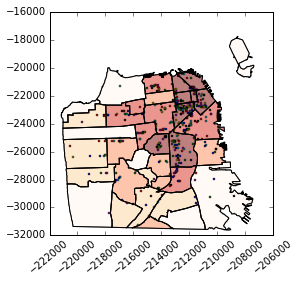

In [53]:
sf_bars_loc[sf_bars_loc.intersects(neighs.unary_union)].plot()
gpd.GeoDataFrame(bars_p_sqmi,geometry=neighs.geometry,crs=neighs.crs).plot(column='BarsPSqMi', scheme='QUANTILES', colormap='OrRd')
fig=plt.xticks(rotation=40)

## Export Bar GeoDataframe to Shapefile

GeoPandas makes this very easy!

In [110]:
sf_bars_loc.to_file('Data/sf_bar_locations.shp')